In [1]:
import random
import networkx as nx
import numpy as np
import karateclub
from tkinter import _flatten
import community
import MGCF
import MGCF_noPrior
import MGCF_noGumbel

### 1. Generate $K$ and $M$

In [2]:
K = random.randint(5, 10)
M = random.randint(1, 100)
print(K)

9


### 2. Gnerate Nodes

In [3]:
average_cluster_size = random.randint(20, 40)

center_x_list = []
center_y_list = []
for i in range(K):
    center_x_list.append(round(10*random.random(), 4))
    center_y_list.append(round(10*random.random(), 4))
node_groundtruth = {}
node_location = {}
idx = 0
for i in range(K):
    for j in range(average_cluster_size):
        node_groundtruth[idx] = i
        node_location[idx] = [center_x_list[i] + round(random.gauss(0, 1), 4), center_y_list[i] + round(random.gauss(0, 1), 4)]
        idx = idx + 1
N = len(node_groundtruth)
print('节点总数', N)
G = nx.Graph()
G.add_nodes_from(list(range(N)))

# ground_truth = {}
# for k, v in node_groundtruth.items():
#     if v not in ground_truth:
#         ground_truth[v] = [k]
#     else:
#         ground_truth[v].append(k)

节点总数 261


### 3. k-nearest neighborhood

In [4]:
loc_np = np.array(list(node_location.values()))
x_np = loc_np[:, 0].reshape((1, -1))
y_np = loc_np[:, 1].reshape((1, -1))
distance_np = np.square(x_np - x_np.T)+np.square(y_np - y_np.T)
k_nearest = {}
kk = int(average_cluster_size/2)
for i in range(N):
    k_near_pre = list(np.argsort(distance_np[i])[:kk+1:])
    k_near_pre.remove(i)
    k_nearest[i] = k_near_pre
for i in range(N):
    for j in k_nearest[i]:
        G.add_edge(i, j, weight = np.exp(-1/2*distance_np[i, j]))
        
G.to_undirected()

### 4. Generate $f_{k, m}$

In [5]:
omega = 1/K*np.ones(K)
beta = 1/M*np.ones(M)
F = omega.reshape((1, -1))*beta.reshape((-1, 1))
F = F*K*M
# F [M, K]
print(average_cluster_size)

29


### 5. Allocate for $X$

In [6]:
X = np.zeros((N, M))
for i in range(M):
    for j in range(K):
        tmp = np.random.dirichlet(np.ones(average_cluster_size), size=1)*F[i, j]
        X[j*average_cluster_size:(j+1)*average_cluster_size:, i] = tmp

### 6. for Algorithm Process & Evaluation

In [7]:
# 1. Ours
partition = MGCF.main(clusters_number=K, feature=X, multi_graph=[G], alpha_1=1, alpha_2=0.5, alpha_3=0.001, weight_list=[1], alpha=2, epoch_num=200)
remap = list(set(partition.values()))
for k, v in partition.items():
    partition[k] = remap.index(v)
labels_pred = partition
partition_2 = {}
for i in range(len(labels_pred)):
    if labels_pred[i] not in partition_2:
        partition_2[labels_pred[i]] = [i]
    else:
        partition_2[labels_pred[i]].append(i)
cn = len(partition_2)
U = np.zeros((cn, N))
for k, v in partition.items():
    U[v, k] = 1
    
print(round(community.modularity(partition, G, weight='weight'), 3))
print(round(np.sqrt(np.sum(np.square(np.dot(np.dot(U, X), beta) / np.sum(np.dot(np.dot(U, X), beta))  - np.ones(cn)/cn))), 3))

0.754
0.136


In [8]:
# 2. Ours-noP
partition = MGCF.main(clusters_number=K, feature=X, multi_graph=[G], alpha_1=1, alpha_2=0.5, alpha_3=0, weight_list=[1], alpha=2, epoch_num=180)
remap = list(set(partition.values()))
for k, v in partition.items():
    partition[k] = remap.index(v)
labels_pred = partition
partition_2 = {}
for i in range(len(labels_pred)):
    if labels_pred[i] not in partition_2:
        partition_2[labels_pred[i]] = [i]
    else:
        partition_2[labels_pred[i]].append(i)
cn = len(partition_2)
U = np.zeros((cn, N))
for k, v in partition.items():
    U[v, k] = 1
    
print(round(community.modularity(partition, G, weight='weight'), 3))
print(round(np.sqrt(np.sum(np.square(np.dot(np.dot(U, X), beta) / np.sum(np.dot(np.dot(U, X), beta))  - np.ones(cn)/cn))), 3))

0.746
0.118


In [9]:
# 3. Ours-noPrior
partition = MGCF_noPrior.main(clusters_number=K, feature=X, multi_graph=[G], alpha_1=1, alpha_2=0.5, alpha_3=0, weight_list=[1], alpha=2, epoch_num=200)
remap = list(set(partition.values()))
for k, v in partition.items():
    partition[k] = remap.index(v)
labels_pred = partition
partition_2 = {}
for i in range(len(labels_pred)):
    if labels_pred[i] not in partition_2:
        partition_2[labels_pred[i]] = [i]
    else:
        partition_2[labels_pred[i]].append(i)
cn = len(partition_2)
U = np.zeros((cn, N))
for k, v in partition.items():
    U[v, k] = 1
    
print(round(community.modularity(partition, G, weight='weight'), 3))
print(round(np.sqrt(np.sum(np.square(np.dot(np.dot(U, X), beta) / np.sum(np.dot(np.dot(U, X), beta))  - np.ones(cn)/cn))), 3))

0.267
0.097


In [10]:
# 4. Ours-noGumbel
partition = MGCF_noGumbel.main(clusters_number=K, feature=X, multi_graph=[G], alpha_1=1, alpha_2=0.5, alpha_3=0, weight_list=[1], alpha=2, epoch_num=100)
remap = list(set(partition.values()))
for k, v in partition.items():
    partition[k] = remap.index(v)
labels_pred = partition
partition_2 = {}
for i in range(len(labels_pred)):
    if labels_pred[i] not in partition_2:
        partition_2[labels_pred[i]] = [i]
    else:
        partition_2[labels_pred[i]].append(i)
cn = len(partition_2)
U = np.zeros((cn, N))
for k, v in partition.items():
    U[v, k] = 1
    
print(round(community.modularity(partition, G, weight='weight'), 3))
print(round(np.sqrt(np.sum(np.square(np.dot(np.dot(U, X), beta) / np.sum(np.dot(np.dot(U, X), beta))  - np.ones(cn)/cn))), 3))

0.1
0.382


### 7. Visualization

In [11]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
from tqdm import tqdm
plt.rc('font', family='Times New Roman')

### $\gamma_1$

In [43]:
x = '$\gamma_1$'
Q_list_ours = []
Q_list_ours_noP = []
Q_list_ours_noPrior = []
Q_list_ours_noGumbel = []
L_list_ours = []
L_list_ours_noP = []
L_list_ours_noPrior = []
L_list_ours_noGumbel = []
x_list = list(np.arange(0, 7, 1))

for gamma_1 in tqdm(x_list):
    
    # 1. Ours ######################################################################
    partition = MGCF.main(clusters_number=K, feature=X, multi_graph=[G], alpha_1=1, alpha_2=gamma_1, alpha_3=0.001, weight_list=[1], alpha=2, epoch_num=150)
    remap = list(set(partition.values()))
    for k, v in partition.items():
        partition[k] = remap.index(v)
    labels_pred = partition
    partition_2 = {}
    for i in range(len(labels_pred)):
        if labels_pred[i] not in partition_2:
            partition_2[labels_pred[i]] = [i]
        else:
            partition_2[labels_pred[i]].append(i)
    cn = len(partition_2)
    U = np.zeros((cn, N))
    for k, v in partition.items():
        U[v, k] = 1
    Q_list_ours.append(round(community.modularity(partition, G, weight='weight'), 3))
    L_list_ours.append(round(np.sqrt(np.sum(np.square(np.dot(np.dot(U, X), beta) / np.sum(np.dot(np.dot(U, X), beta))  - np.ones(cn)/cn))), 3))
    
    # 2. Ours-noP ######################################################################
    partition = MGCF.main(clusters_number=K, feature=X, multi_graph=[G], alpha_1=1, alpha_2=gamma_1, alpha_3=0, weight_list=[1], alpha=2, epoch_num=130)
    remap = list(set(partition.values()))
    for k, v in partition.items():
        partition[k] = remap.index(v)
    labels_pred = partition
    partition_2 = {}
    for i in range(len(labels_pred)):
        if labels_pred[i] not in partition_2:
            partition_2[labels_pred[i]] = [i]
        else:
            partition_2[labels_pred[i]].append(i)
    cn = len(partition_2)
    U = np.zeros((cn, N))
    for k, v in partition.items():
        U[v, k] = 1
    Q_list_ours_noP.append(round(community.modularity(partition, G, weight='weight'), 3))
    L_list_ours_noP.append(round(np.sqrt(np.sum(np.square(np.dot(np.dot(U, X), beta) / np.sum(np.dot(np.dot(U, X), beta))  - np.ones(cn)/cn))), 3))
    
    # 3. Ours-noPrior ######################################################################
    partition = MGCF_noPrior.main(clusters_number=K, feature=X, multi_graph=[G], alpha_1=1, alpha_2=gamma_1, alpha_3=0, weight_list=[1], alpha=2, epoch_num=200)
    remap = list(set(partition.values()))
    for k, v in partition.items():
        partition[k] = remap.index(v)
    labels_pred = partition
    partition_2 = {}
    for i in range(len(labels_pred)):
        if labels_pred[i] not in partition_2:
            partition_2[labels_pred[i]] = [i]
        else:
            partition_2[labels_pred[i]].append(i)
    cn = len(partition_2)
    U = np.zeros((cn, N))
    for k, v in partition.items():
        U[v, k] = 1
    Q_list_ours_noPrior.append(round(community.modularity(partition, G, weight='weight'), 3))
    L_list_ours_noPrior.append(round(np.sqrt(np.sum(np.square(np.dot(np.dot(U, X), beta) / np.sum(np.dot(np.dot(U, X), beta))  - np.ones(cn)/cn))), 3))
    
    # 4. Ours-noGumbel ######################################################################
    partition = MGCF_noGumbel.main(clusters_number=K, feature=X, multi_graph=[G], alpha_1=1, alpha_2=gamma_1, alpha_3=0.1, weight_list=[1], alpha=2, epoch_num=100)
    remap = list(set(partition.values()))
    for k, v in partition.items():
        partition[k] = remap.index(v)
    labels_pred = partition
    partition_2 = {}
    for i in range(len(labels_pred)):
        if labels_pred[i] not in partition_2:
            partition_2[labels_pred[i]] = [i]
        else:
            partition_2[labels_pred[i]].append(i)
    cn = len(partition_2)
    U = np.zeros((cn, N))
    for k, v in partition.items():
        U[v, k] = 1
    Q_list_ours_noGumbel.append(round(community.modularity(partition, G, weight='weight'), 3))
    L_list_ours_noGumbel.append(round(np.sqrt(np.sum(np.square(np.dot(np.dot(U, X), beta) / np.sum(np.dot(np.dot(U, X), beta))  - np.ones(cn)/cn))), 3))

100%|██████████| 7/7 [02:30<00:00, 21.47s/it]


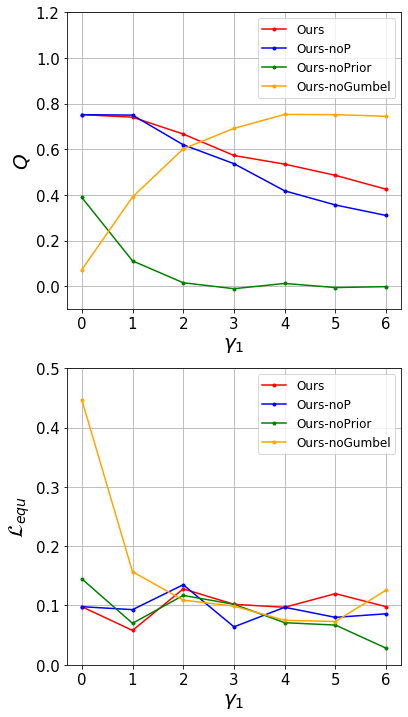

In [45]:
legend_size = 12
ticks_size = 15
label_size = 20
plt.figure(figsize=(6, 12))

plt.subplot(2, 1, 1)
plt.ylim([-0.1, 1.2])
plt.plot(x_list, Q_list_ours, color='red', marker='.', label='Ours')
plt.plot(x_list, Q_list_ours_noP, color='blue', marker='.', label='Ours-noP')
plt.plot(x_list, Q_list_ours_noPrior, color='green', marker='.', label='Ours-noPrior')
plt.plot(x_list, Q_list_ours_noGumbel, color='orange', marker='.', label='Ours-noGumbel')
plt.xlabel(x, fontsize=label_size)
plt.ylabel('$Q$', fontsize=label_size)
plt.xticks(fontsize=ticks_size)
plt.yticks(fontsize=ticks_size)
plt.legend(fontsize=legend_size)
plt.grid('both')

plt.subplot(2, 1, 2)
plt.ylim([0, 0.5])
plt.plot(x_list, L_list_ours, color='red', marker='.', label='Ours')
plt.plot(x_list, L_list_ours_noP, color='blue', marker='.', label='Ours-noP')
plt.plot(x_list, L_list_ours_noPrior, color='green', marker='.', label='Ours-noPrior')
plt.plot(x_list, L_list_ours_noGumbel, color='orange', marker='.', label='Ours-noGumbel')
plt.xlabel(x, fontsize=label_size)
plt.ylabel('$\mathcal{L}_{equ}$', fontsize=label_size)
plt.xticks(fontsize=ticks_size)
plt.yticks(fontsize=ticks_size)
plt.legend(fontsize=legend_size)
plt.grid('both')

plt.savefig('./experiment_result/figure/sensitivity_'+x+'.png', dps=500)

### $K$

In [19]:
x = '$K$'
Q_list_ours = []
Q_list_ours_noP = []
Q_list_ours_noPrior = []
Q_list_ours_noGumbel = []
L_list_ours = []
L_list_ours_noP = []
L_list_ours_noPrior = []
L_list_ours_noGumbel = []
x_list = list(np.arange(5, 14, 1))

for K in tqdm(x_list):
    
    # 1. Ours ######################################################################
    partition = MGCF.main(clusters_number=K, feature=X, multi_graph=[G], alpha_1=1, alpha_2=0.5, alpha_3=0.001, weight_list=[1], alpha=2, epoch_num=150)
    remap = list(set(partition.values()))
    for k, v in partition.items():
        partition[k] = remap.index(v)
    labels_pred = partition
    partition_2 = {}
    for i in range(len(labels_pred)):
        if labels_pred[i] not in partition_2:
            partition_2[labels_pred[i]] = [i]
        else:
            partition_2[labels_pred[i]].append(i)
    cn = len(partition_2)
    U = np.zeros((cn, N))
    for k, v in partition.items():
        U[v, k] = 1
    Q_list_ours.append(round(community.modularity(partition, G, weight='weight'), 3))
    L_list_ours.append(round(np.sqrt(np.sum(np.square(np.dot(np.dot(U, X), beta) / np.sum(np.dot(np.dot(U, X), beta))  - np.ones(cn)/cn))), 3))
    
    # 2. Ours-noP ######################################################################
    partition = MGCF.main(clusters_number=K, feature=X, multi_graph=[G], alpha_1=1, alpha_2=0.5, alpha_3=0, weight_list=[1], alpha=2, epoch_num=100)
    remap = list(set(partition.values()))
    for k, v in partition.items():
        partition[k] = remap.index(v)
    labels_pred = partition
    partition_2 = {}
    for i in range(len(labels_pred)):
        if labels_pred[i] not in partition_2:
            partition_2[labels_pred[i]] = [i]
        else:
            partition_2[labels_pred[i]].append(i)
    cn = len(partition_2)
    U = np.zeros((cn, N))
    for k, v in partition.items():
        U[v, k] = 1
    Q_list_ours_noP.append(round(community.modularity(partition, G, weight='weight'), 3))
    L_list_ours_noP.append(round(np.sqrt(np.sum(np.square(np.dot(np.dot(U, X), beta) / np.sum(np.dot(np.dot(U, X), beta))  - np.ones(cn)/cn))), 3))
    
    # 3. Ours-noPrior ######################################################################
    partition = MGCF_noPrior.main(clusters_number=K, feature=X, multi_graph=[G], alpha_1=1, alpha_2=0.5, alpha_3=0, weight_list=[1], alpha=2, epoch_num=200)
    remap = list(set(partition.values()))
    for k, v in partition.items():
        partition[k] = remap.index(v)
    labels_pred = partition
    partition_2 = {}
    for i in range(len(labels_pred)):
        if labels_pred[i] not in partition_2:
            partition_2[labels_pred[i]] = [i]
        else:
            partition_2[labels_pred[i]].append(i)
    cn = len(partition_2)
    U = np.zeros((cn, N))
    for k, v in partition.items():
        U[v, k] = 1
    Q_list_ours_noPrior.append(round(community.modularity(partition, G, weight='weight'), 3))
    L_list_ours_noPrior.append(round(np.sqrt(np.sum(np.square(np.dot(np.dot(U, X), beta) / np.sum(np.dot(np.dot(U, X), beta))  - np.ones(cn)/cn))), 3))
    
    # 4. Ours-noGumbel ######################################################################
    partition = MGCF_noGumbel.main(clusters_number=K, feature=X, multi_graph=[G], alpha_1=1, alpha_2=0.5, alpha_3=0.01, weight_list=[1], alpha=2, epoch_num=100)
    remap = list(set(partition.values()))
    for k, v in partition.items():
        partition[k] = remap.index(v)
    labels_pred = partition
    partition_2 = {}
    for i in range(len(labels_pred)):
        if labels_pred[i] not in partition_2:
            partition_2[labels_pred[i]] = [i]
        else:
            partition_2[labels_pred[i]].append(i)
    cn = len(partition_2)
    U = np.zeros((cn, N))
    for k, v in partition.items():
        U[v, k] = 1
    Q_list_ours_noGumbel.append(round(community.modularity(partition, G, weight='weight'), 3))
    L_list_ours_noGumbel.append(round(np.sqrt(np.sum(np.square(np.dot(np.dot(U, X), beta) / np.sum(np.dot(np.dot(U, X), beta))  - np.ones(cn)/cn))), 3))

100%|██████████| 9/9 [02:55<00:00, 19.46s/it]


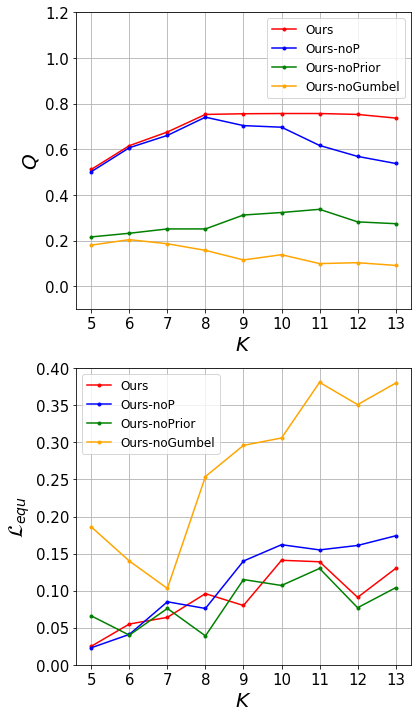

In [23]:
legend_size = 12
ticks_size = 15
label_size = 20
plt.figure(figsize=(6, 12))

plt.subplot(2, 1, 1)
plt.ylim([-0.1, 1.2])
plt.plot(x_list, Q_list_ours, color='red', marker='.', label='Ours')
plt.plot(x_list, Q_list_ours_noP, color='blue', marker='.', label='Ours-noP')
plt.plot(x_list, Q_list_ours_noPrior, color='green', marker='.', label='Ours-noPrior')
plt.plot(x_list, Q_list_ours_noGumbel, color='orange', marker='.', label='Ours-noGumbel')
plt.xlabel(x, fontsize=label_size)
plt.ylabel('$Q$', fontsize=label_size)
plt.xticks(fontsize=ticks_size)
plt.yticks(fontsize=ticks_size)
plt.legend(fontsize=legend_size)
plt.grid('both')

plt.subplot(2, 1, 2)
plt.ylim([0, 0.4])
plt.plot(x_list, L_list_ours, color='red', marker='.', label='Ours')
plt.plot(x_list, L_list_ours_noP, color='blue', marker='.', label='Ours-noP')
plt.plot(x_list, L_list_ours_noPrior, color='green', marker='.', label='Ours-noPrior')
plt.plot(x_list, L_list_ours_noGumbel, color='orange', marker='.', label='Ours-noGumbel')
plt.xlabel(x, fontsize=label_size)
plt.ylabel('$\mathcal{L}_{equ}$', fontsize=label_size)
plt.xticks(fontsize=ticks_size)
plt.yticks(fontsize=ticks_size)
plt.legend(fontsize=legend_size)
plt.grid('both')

plt.savefig('./experiment_result/figure/sensitivity_'+x+'.png', dps=500)

### $N$

In [24]:
x = '$N$'
Q_list_ours = []
Q_list_ours_noP = []
Q_list_ours_noPrior = []
Q_list_ours_noGumbel = []
L_list_ours = []
L_list_ours_noP = []
L_list_ours_noPrior = []
L_list_ours_noGumbel = []
x_list = list(np.arange(100, 3500, 400))

for n in tqdm(x_list):
    
    K = random.randint(3, 15)
    M = random.randint(1, 50)
    
    average_cluster_size = int(n/K)
    center_x_list = []
    center_y_list = []
    for i in range(K):
        center_x_list.append(round(10*random.random(), 4))
        center_y_list.append(round(10*random.random(), 4))
    node_groundtruth = {}
    node_location = {}
    idx = 0
    for i in range(K):
        for j in range(average_cluster_size):
            node_groundtruth[idx] = i
            node_location[idx] = [center_x_list[i] + round(random.gauss(0, 1), 4), center_y_list[i] + round(random.gauss(0, 1), 4)]
            idx = idx + 1
    N = len(node_groundtruth)
    G = nx.Graph()
    G.add_nodes_from(list(range(N)))
    
    loc_np = np.array(list(node_location.values()))
    x_np = loc_np[:, 0].reshape((1, -1))
    y_np = loc_np[:, 1].reshape((1, -1))
    distance_np = np.square(x_np - x_np.T)+np.square(y_np - y_np.T)
    k_nearest = {}
    kk = int(average_cluster_size/2)
    for i in range(N):
        k_near_pre = list(np.argsort(distance_np[i])[:kk+1:])
        k_near_pre.remove(i)
        k_nearest[i] = k_near_pre
    for i in range(N):
        for j in k_nearest[i]:
            G.add_edge(i, j, weight = np.exp(-1/2*distance_np[i, j]))
    G.to_undirected()

    omega = 1/K*np.ones(K)
    beta = 1/M*np.ones(M)
    F = omega.reshape((1, -1))*beta.reshape((-1, 1))
    F = F*K*M
    
    X = np.zeros((N, M))
    for i in range(M):
        for j in range(K):
            tmp = np.random.dirichlet(np.ones(average_cluster_size), size=1)*F[i, j]
            X[j*average_cluster_size:(j+1)*average_cluster_size:, i] = tmp

    # 1. Ours ######################################################################
    partition = MGCF.main(clusters_number=K, feature=X, multi_graph=[G], alpha_1=1, alpha_2=0.5, alpha_3=0.001, weight_list=[1], alpha=2, epoch_num=150)
    remap = list(set(partition.values()))
    for k, v in partition.items():
        partition[k] = remap.index(v)
    labels_pred = partition
    partition_2 = {}
    for i in range(len(labels_pred)):
        if labels_pred[i] not in partition_2:
            partition_2[labels_pred[i]] = [i]
        else:
            partition_2[labels_pred[i]].append(i)
    cn = len(partition_2)
    U = np.zeros((cn, N))
    for k, v in partition.items():
        U[v, k] = 1
    Q_list_ours.append(round(community.modularity(partition, G, weight='weight'), 3))
    L_list_ours.append(round(np.sqrt(np.sum(np.square(np.dot(np.dot(U, X), beta) / np.sum(np.dot(np.dot(U, X), beta))  - np.ones(cn)/cn))), 3))
    
    # 2. Ours-noP ######################################################################
    partition = MGCF.main(clusters_number=K, feature=X, multi_graph=[G], alpha_1=1, alpha_2=0.5, alpha_3=0, weight_list=[1], alpha=2, epoch_num=130)
    remap = list(set(partition.values()))
    for k, v in partition.items():
        partition[k] = remap.index(v)
    labels_pred = partition
    partition_2 = {}
    for i in range(len(labels_pred)):
        if labels_pred[i] not in partition_2:
            partition_2[labels_pred[i]] = [i]
        else:
            partition_2[labels_pred[i]].append(i)
    cn = len(partition_2)
    U = np.zeros((cn, N))
    for k, v in partition.items():
        U[v, k] = 1
    Q_list_ours_noP.append(round(community.modularity(partition, G, weight='weight'), 3))
    L_list_ours_noP.append(round(np.sqrt(np.sum(np.square(np.dot(np.dot(U, X), beta) / np.sum(np.dot(np.dot(U, X), beta))  - np.ones(cn)/cn))), 3))
    
    # 3. Ours-noPrior ######################################################################
    partition = MGCF_noPrior.main(clusters_number=K, feature=X, multi_graph=[G], alpha_1=1, alpha_2=0.5, alpha_3=0, weight_list=[1], alpha=2, epoch_num=200)
    remap = list(set(partition.values()))
    for k, v in partition.items():
        partition[k] = remap.index(v)
    labels_pred = partition
    partition_2 = {}
    for i in range(len(labels_pred)):
        if labels_pred[i] not in partition_2:
            partition_2[labels_pred[i]] = [i]
        else:
            partition_2[labels_pred[i]].append(i)
    cn = len(partition_2)
    U = np.zeros((cn, N))
    for k, v in partition.items():
        U[v, k] = 1
    Q_list_ours_noPrior.append(round(community.modularity(partition, G, weight='weight'), 3))
    L_list_ours_noPrior.append(round(np.sqrt(np.sum(np.square(np.dot(np.dot(U, X), beta) / np.sum(np.dot(np.dot(U, X), beta))  - np.ones(cn)/cn))), 3))
    
    # 4. Ours-noGumbel ######################################################################
    partition = MGCF_noGumbel.main(clusters_number=K, feature=X, multi_graph=[G], alpha_1=1, alpha_2=0.5, alpha_3=0.1, weight_list=[1], alpha=2, epoch_num=100)
    remap = list(set(partition.values()))
    for k, v in partition.items():
        partition[k] = remap.index(v)
    labels_pred = partition
    partition_2 = {}
    for i in range(len(labels_pred)):
        if labels_pred[i] not in partition_2:
            partition_2[labels_pred[i]] = [i]
        else:
            partition_2[labels_pred[i]].append(i)
    cn = len(partition_2)
    U = np.zeros((cn, N))
    for k, v in partition.items():
        U[v, k] = 1
    Q_list_ours_noGumbel.append(round(community.modularity(partition, G, weight='weight'), 3))
    L_list_ours_noGumbel.append(round(np.sqrt(np.sum(np.square(np.dot(np.dot(U, X), beta) / np.sum(np.dot(np.dot(U, X), beta))  - np.ones(cn)/cn))), 3))

100%|██████████| 9/9 [07:19<00:00, 48.85s/it]


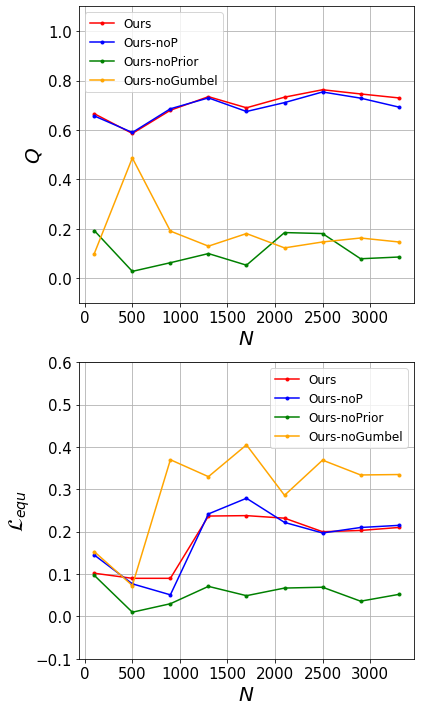

In [29]:
legend_size = 12
ticks_size = 15
label_size = 20
plt.figure(figsize=(6, 12))

plt.subplot(2, 1, 1)
plt.ylim([-0.1, 1.1])
plt.plot(x_list, Q_list_ours, color='red', marker='.', label='Ours')
plt.plot(x_list, Q_list_ours_noP, color='blue', marker='.', label='Ours-noP')
plt.plot(x_list, Q_list_ours_noPrior, color='green', marker='.', label='Ours-noPrior')
plt.plot(x_list, Q_list_ours_noGumbel, color='orange', marker='.', label='Ours-noGumbel')
plt.xlabel(x, fontsize=label_size)
plt.ylabel('$Q$', fontsize=label_size)
plt.xticks(fontsize=ticks_size)
plt.yticks(fontsize=ticks_size)
plt.legend(fontsize=legend_size)
plt.grid('both')

plt.subplot(2, 1, 2)
plt.ylim([-0.1, 0.6])
plt.plot(x_list, L_list_ours, color='red', marker='.', label='Ours')
plt.plot(x_list, L_list_ours_noP, color='blue', marker='.', label='Ours-noP')
plt.plot(x_list, L_list_ours_noPrior, color='green', marker='.', label='Ours-noPrior')
plt.plot(x_list, L_list_ours_noGumbel, color='orange', marker='.', label='Ours-noGumbel')
plt.xlabel(x, fontsize=label_size)
plt.ylabel('$\mathcal{L}_{equ}$', fontsize=label_size)
plt.xticks(fontsize=ticks_size)
plt.yticks(fontsize=ticks_size)
plt.legend(fontsize=legend_size)
plt.grid('both')

plt.savefig('./experiment_result/figure/sensitivity_'+x+'.png', dps=500)

### $I$

In [30]:
import copy

In [36]:
x = '$I$'
Q_list_ours = []
Q_list_ours_noP = []
Q_list_ours_noPrior = []
Q_list_ours_noGumbel = []
L_list_ours = []
L_list_ours_noP = []
L_list_ours_noPrior = []
L_list_ours_noGumbel = []
x_list = list(np.arange(1, 11, 1))

for I in tqdm(x_list):
    
    K = 10
    M = 20
    N = 200
    average_cluster_size = int(N/K)
    ######################################################################
    multi_graph = []
    
    for ii in range(I):
        center_x_list = []
        center_y_list = []
        for i in range(K):
            center_x_list.append(round(10*random.random(), 4))
            center_y_list.append(round(10*random.random(), 4))
        node_groundtruth = {}
        node_location = {}
        idx = 0
        for i in range(K):
            for j in range(average_cluster_size):
                node_groundtruth[idx] = i
                node_location[idx] = [center_x_list[i] + round(random.gauss(0, 1), 4), center_y_list[i] + round(random.gauss(0, 1), 4)]
                idx = idx + 1
        # N = len(node_groundtruth)
        G = nx.Graph()
        G.add_nodes_from(list(range(N)))

        loc_np = np.array(list(node_location.values()))
        x_np = loc_np[:, 0].reshape((1, -1))
        y_np = loc_np[:, 1].reshape((1, -1))
        distance_np = np.square(x_np - x_np.T)+np.square(y_np - y_np.T)
        k_nearest = {}
        kk = int(average_cluster_size/2)
        for i in range(N):
            k_near_pre = list(np.argsort(distance_np[i])[:kk+1:])
            k_near_pre.remove(i)
            k_nearest[i] = k_near_pre
        for i in range(N):
            for j in k_nearest[i]:
                G.add_edge(i, j, weight = np.exp(-1/2*distance_np[i, j]))
        G.to_undirected()
        multi_graph.append(copy.deepcopy(G))
    
    ######################################################################
    omega = 1/K*np.ones(K)
    beta = 1/M*np.ones(M)
    F = omega.reshape((1, -1))*beta.reshape((-1, 1))
    F = F*K*M
    X = np.zeros((N, M))
    for i in range(M):
        for j in range(K):
            tmp = np.random.dirichlet(np.ones(average_cluster_size), size=1)*F[i, j]
            X[j*average_cluster_size:(j+1)*average_cluster_size:, i] = tmp

    # 1. Ours ######################################################################
    partition = MGCF.main(clusters_number=K, feature=X, multi_graph=multi_graph, alpha_1=1, alpha_2=0.5, alpha_3=0.001, weight_list=[1], alpha=2, epoch_num=150)
    remap = list(set(partition.values()))
    for k, v in partition.items():
        partition[k] = remap.index(v)
    labels_pred = partition
    partition_2 = {}
    for i in range(len(labels_pred)):
        if labels_pred[i] not in partition_2:
            partition_2[labels_pred[i]] = [i]
        else:
            partition_2[labels_pred[i]].append(i)
    cn = len(partition_2)
    U = np.zeros((cn, N))
    for k, v in partition.items():
        U[v, k] = 1
    mod = 0
    for graph in multi_graph:
        mod = mod + community.modularity(partition, graph, weight='weight')
    Q_list_ours.append(round(mod/len(multi_graph), 3))
    L_list_ours.append(round(np.sqrt(np.sum(np.square(np.dot(np.dot(U, X), beta) / np.sum(np.dot(np.dot(U, X), beta))  - np.ones(cn)/cn))), 3))
    
    # 2. Ours-noP ######################################################################
    partition = MGCF.main(clusters_number=K, feature=X, multi_graph=multi_graph, alpha_1=1, alpha_2=0.5, alpha_3=0, weight_list=[1], alpha=2, epoch_num=130)
    remap = list(set(partition.values()))
    for k, v in partition.items():
        partition[k] = remap.index(v)
    labels_pred = partition
    partition_2 = {}
    for i in range(len(labels_pred)):
        if labels_pred[i] not in partition_2:
            partition_2[labels_pred[i]] = [i]
        else:
            partition_2[labels_pred[i]].append(i)
    cn = len(partition_2)
    U = np.zeros((cn, N))
    for k, v in partition.items():
        U[v, k] = 1
    mod = 0
    for graph in multi_graph:
        mod = mod + community.modularity(partition, graph, weight='weight')
    Q_list_ours_noP.append(round(mod/len(multi_graph), 3))
    L_list_ours_noP.append(round(np.sqrt(np.sum(np.square(np.dot(np.dot(U, X), beta) / np.sum(np.dot(np.dot(U, X), beta))  - np.ones(cn)/cn))), 3))
    
    # 3. Ours-noPrior ######################################################################
    partition = MGCF_noPrior.main(clusters_number=K, feature=X, multi_graph=multi_graph, alpha_1=1, alpha_2=0.5, alpha_3=0, weight_list=[1], alpha=2, epoch_num=200)
    remap = list(set(partition.values()))
    for k, v in partition.items():
        partition[k] = remap.index(v)
    labels_pred = partition
    partition_2 = {}
    for i in range(len(labels_pred)):
        if labels_pred[i] not in partition_2:
            partition_2[labels_pred[i]] = [i]
        else:
            partition_2[labels_pred[i]].append(i)
    cn = len(partition_2)
    U = np.zeros((cn, N))
    for k, v in partition.items():
        U[v, k] = 1
    mod = 0
    for graph in multi_graph:
        mod = mod + community.modularity(partition, graph, weight='weight')
    Q_list_ours_noPrior.append(round(mod/len(multi_graph), 3))
    L_list_ours_noPrior.append(round(np.sqrt(np.sum(np.square(np.dot(np.dot(U, X), beta) / np.sum(np.dot(np.dot(U, X), beta))  - np.ones(cn)/cn))), 3))
    
    # 4. Ours-noGumbel ######################################################################
    partition = MGCF_noGumbel.main(clusters_number=K, feature=X, multi_graph=multi_graph, alpha_1=1, alpha_2=0.5, alpha_3=0.1, weight_list=[1], alpha=2, epoch_num=100)
    remap = list(set(partition.values()))
    for k, v in partition.items():
        partition[k] = remap.index(v)
    labels_pred = partition
    partition_2 = {}
    for i in range(len(labels_pred)):
        if labels_pred[i] not in partition_2:
            partition_2[labels_pred[i]] = [i]
        else:
            partition_2[labels_pred[i]].append(i)
    cn = len(partition_2)
    U = np.zeros((cn, N))
    for k, v in partition.items():
        U[v, k] = 1
    mod = 0
    for graph in multi_graph:
        mod = mod + community.modularity(partition, graph, weight='weight')
    Q_list_ours_noGumbel.append(round(mod/len(multi_graph), 3))
    L_list_ours_noGumbel.append(round(np.sqrt(np.sum(np.square(np.dot(np.dot(U, X), beta) / np.sum(np.dot(np.dot(U, X), beta))  - np.ones(cn)/cn))), 3))

100%|██████████| 10/10 [15:05<00:00, 90.51s/it] 


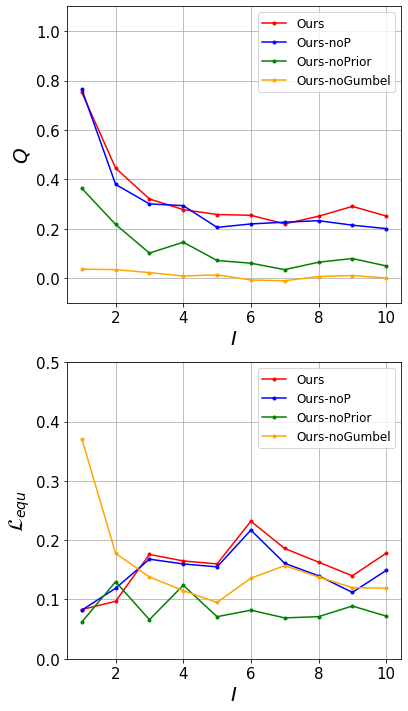

In [42]:
legend_size = 12
ticks_size = 15
label_size = 20
plt.figure(figsize=(6, 12))

plt.subplot(2, 1, 1)
plt.ylim([-0.1, 1.1])
plt.plot(x_list, Q_list_ours, color='red', marker='.', label='Ours')
plt.plot(x_list, Q_list_ours_noP, color='blue', marker='.', label='Ours-noP')
plt.plot(x_list, Q_list_ours_noPrior, color='green', marker='.', label='Ours-noPrior')
plt.plot(x_list, Q_list_ours_noGumbel, color='orange', marker='.', label='Ours-noGumbel')
plt.xlabel(x, fontsize=label_size)
plt.ylabel('$Q$', fontsize=label_size)
plt.xticks(fontsize=ticks_size)
plt.yticks(fontsize=ticks_size)
plt.legend(fontsize=legend_size)
plt.grid('both')

plt.subplot(2, 1, 2)
plt.ylim([0, 0.5])
plt.plot(x_list, L_list_ours, color='red', marker='.', label='Ours')
plt.plot(x_list, L_list_ours_noP, color='blue', marker='.', label='Ours-noP')
plt.plot(x_list, L_list_ours_noPrior, color='green', marker='.', label='Ours-noPrior')
plt.plot(x_list, L_list_ours_noGumbel, color='orange', marker='.', label='Ours-noGumbel')
plt.xlabel(x, fontsize=label_size)
plt.ylabel('$\mathcal{L}_{equ}$', fontsize=label_size)
plt.xticks(fontsize=ticks_size)
plt.yticks(fontsize=ticks_size)
plt.legend(fontsize=legend_size)
plt.grid('both')

plt.savefig('./experiment_result/figure/sensitivity_'+x+'.png', dps=500)